In [1]:
import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations

In [2]:
def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

In [3]:
def safe_union_arrays(series):
    all_elements = set()
    for item in series:
        if isinstance(item, str):
            try:
                parsed = ast.literal_eval(item)
                if isinstance(parsed, list):
                    all_elements.update(parsed)
                else:
                    all_elements.add(parsed)  # single value
            except:
                continue
    return all_elements

node_results_path = Path('results/node_results')
dfs = []
for csv_file in node_results_path.glob("*.csv"):
    df = pd.read_csv(csv_file)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

grouped = combined_df.groupby('source_ip')

global_result_df = pd.DataFrame()
global_result_df['source_ip'] = grouped['source_ip'].first()
global_result_df['packet_count'] = grouped['packet_count'].sum()
global_result_df['unique_commands'] = grouped['unique_commands'].sum()
global_result_df['unique_my_ports'] = grouped['unique_my_ports'].apply(safe_union_arrays)
global_result_df['unique_peer_ids'] = grouped['unique_peer_ids'].apply(safe_union_arrays)
global_result_df['has_support_flags'] = grouped['has_support_flags'].any()
global_result_df['unique_source_ports'] = grouped['unique_source_ports'].mean()
global_result_df['ts_latency'] = grouped['ts_latency'].mean()
global_result_df['ping_frequency'] = grouped['ping_frequency'].mean()
global_result_df['total_pings'] = grouped['total_pings'].mean()
global_result_df['handshake_frequency'] = grouped['handshake_frequency'].mean()
global_result_df['total_handshakes'] = grouped['total_handshakes'].mean()
global_result_df['subnet'] = global_result_df['source_ip'].apply(ip_to_subnet)
global_result_df['asn'] = global_result_df['source_ip'].apply(ip_to_asn)
global_result_df['max_pl_sim'] = grouped['max_pl_sim'].mean()
global_result_df['avg_pl_diversity'] = grouped['avg_pl_diversity'].mean()

group_columns = [col for col in combined_df.columns if col.startswith('sim_group_')]
for col in group_columns:
    global_result_df[col] = grouped[col].sum()

dfs = []
for csv_file in node_results_path.glob("*_pl_df.csv"):
    df = pd.read_csv(csv_file)
    dfs.append(df)
global_pl_df = pd.concat(dfs, ignore_index=True)

print(global_result_df.head(5))

                   source_ip  packet_count  unique_commands unique_my_ports  \
source_ip                                                                     
1.145.138.8      1.145.138.8           2.0              2.0         {18080}   
1.158.20.139    1.158.20.139           2.0              2.0         {18080}   
1.158.57.197    1.158.57.197          26.0              4.0         {18080}   
1.160.138.108  1.160.138.108          21.0              4.0         {18080}   
1.160.254.150  1.160.254.150           1.0              1.0         {18080}   

                      unique_peer_ids  has_support_flags  unique_source_ports  \
source_ip                                                                       
1.145.138.8    {16051594327072124928}               True                  1.0   
1.158.20.139    {1769162559250729984}               True                  2.0   
1.158.57.197   {17208858194159509504}               True                  1.0   
1.160.138.108   {9420499685128224768}    

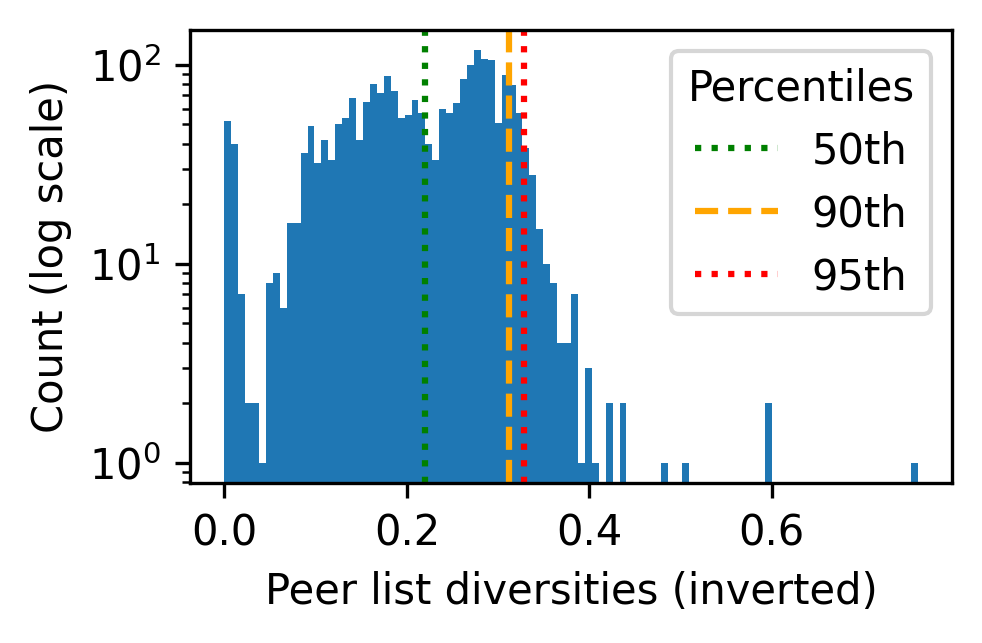

In [4]:
plt.figure(figsize=(3.13, 2), dpi=300)
inverted_data = 1 - global_result_df['avg_pl_diversity']
plt.hist(inverted_data, bins=100, log=True)
plt.axvline(inverted_data.quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(inverted_data.quantile(0.90), color='orange', linestyle='--', label='90th')
plt.axvline(inverted_data.quantile(0.95), color='red', linestyle=':', label='95th')
plt.xlabel(f'Peer list diversities (inverted)')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()

# Peer Lists

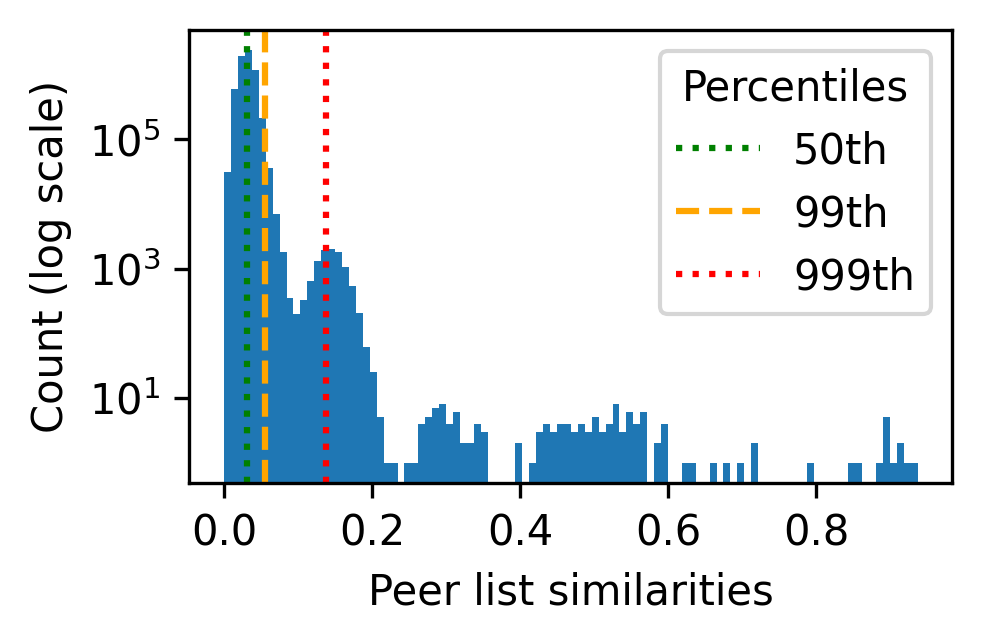

source1_ip
88.198.163.90     12037
37.187.74.171      3721
192.99.8.110       3562
47.7.179.15        1733
68.60.93.104       1196
185.193.226.35     1110
84.185.110.202     1076
194.164.32.12      1022
71.159.58.60        789
84.9.239.64         654
136.47.213.244      632
115.188.69.202      551
66.8.212.113        510
220.233.36.32       502
212.90.62.40        403
176.215.15.137      373
76.133.211.20       325
73.63.192.88        322
142.105.17.58       315
193.164.23.90       284
Name: count, dtype: int64


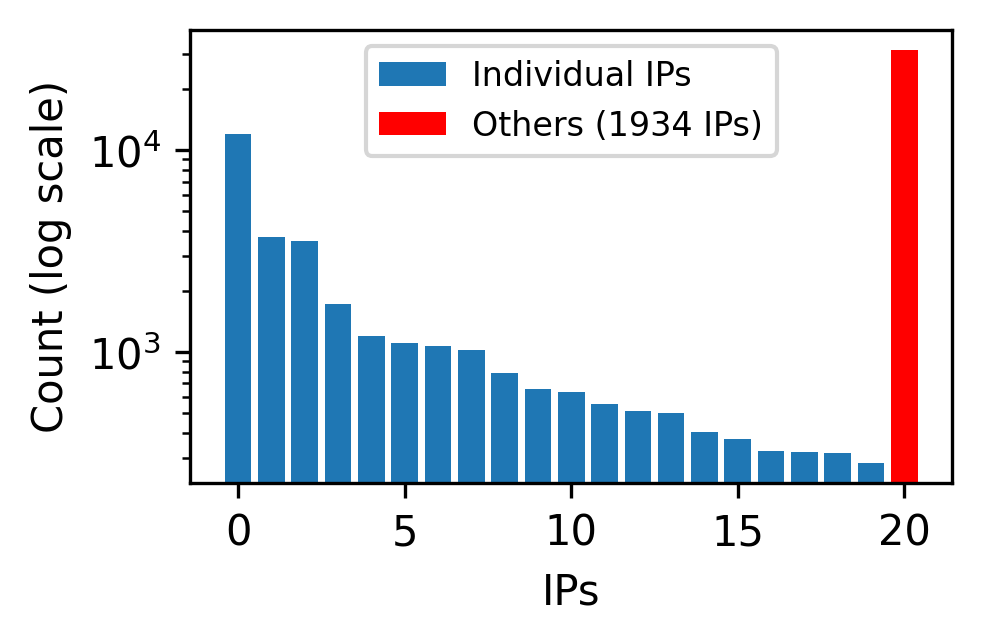

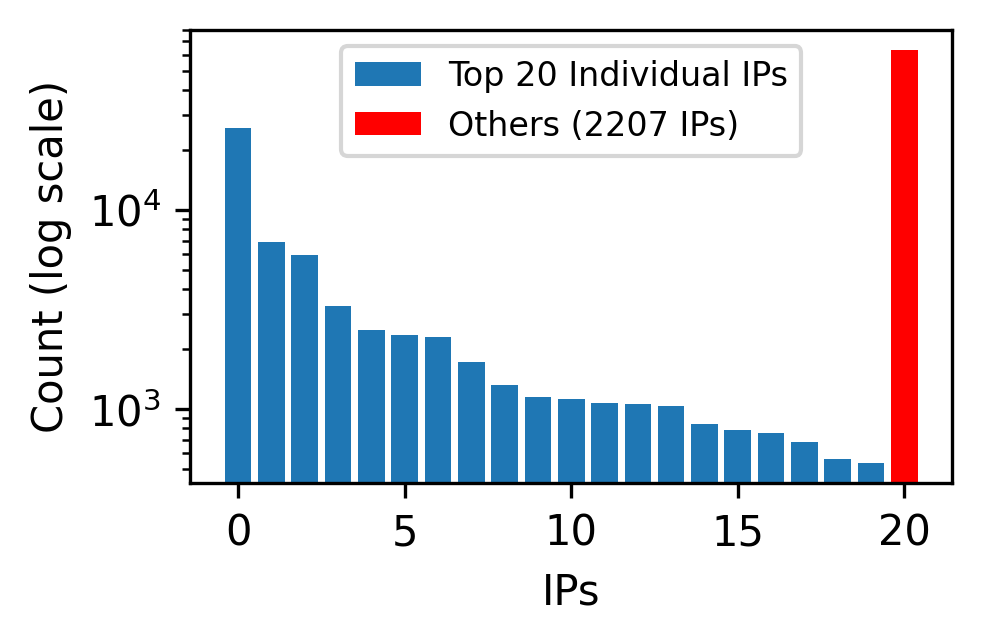

Top 10 IP pairs with highest similarity:
ip_pair
(88.198.163.90, 88.198.163.90)      6987
(192.99.8.110, 88.198.163.90)       3119
(37.187.74.171, 88.198.163.90)      2638
(47.7.179.15, 47.7.179.15)          1081
(192.99.8.110, 37.187.74.171)        993
(68.60.93.104, 68.60.93.104)         861
(84.185.110.202, 84.185.110.202)     820
(185.193.226.35, 185.193.226.35)     703
(192.99.8.110, 192.99.8.110)         606
(115.188.69.202, 115.188.69.202)     475
(37.187.74.171, 37.187.74.171)       433
(84.9.239.64, 84.9.239.64)           421
(194.164.32.12, 89.31.39.48)         396
(194.164.32.12, 194.164.32.12)       231
(66.8.212.113, 66.8.212.113)         231
(136.47.213.244, 136.47.213.244)     231
(71.159.58.60, 88.198.163.90)        222
(107.189.25.121, 107.189.25.121)     210
(220.233.36.32, 220.233.36.32)       210
(193.164.23.90, 193.164.23.90)       190
Name: count, dtype: int64

Self-pairs (same IP): 17411
Distinct pairs: 44967


/tmp/ipykernel_15232/138744421.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_sim_df['ip_pair'] = high_sim_df.apply(


In [ ]:
plt.figure(figsize=(3.13, 2), dpi=300)
plt.hist(global_pl_df['jaccard_similarity'], bins=100, log=True)
plt.axvline(global_pl_df['jaccard_similarity'].quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(global_pl_df['jaccard_similarity'].quantile(0.99), color='orange', linestyle='--', label='99th')
plt.axvline(global_pl_df['jaccard_similarity'].quantile(0.999), color='red', linestyle=':', label='999th')
plt.xlabel(f'Peer list similarities')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()

high_sim_df = global_pl_df[global_pl_df['jaccard_similarity']>global_pl_df['jaccard_similarity'].quantile(0.99)]
#print(high_sim_df.head(1))
#print(len(high_sim_df))
print(high_sim_df['source1_ip'].value_counts().head(20))

all_ips = pd.concat([
    high_sim_df['source1_ip'], 
    high_sim_df['source2_ip']
])

# Get value counts for all IPs
combined_ip_counts = all_ips.value_counts()

# Plot combined results
top_ips = combined_ip_counts.head(20)
others_count = combined_ip_counts.iloc[20:].sum()

plt.figure(figsize=(3.13, 2), dpi=300)
plt.bar(range(len(top_ips)), top_ips.values, label='Top 20 Individual IPs')
plt.bar(len(top_ips), others_count, color='red', 
        label=f'Others ({len(combined_ip_counts) - 20} IPs)')
plt.yscale('log')
plt.xlabel('IPs')
plt.ylabel('Count (log scale)')
#plt.title('IP Frequency')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.2)
plt.show()

high_sim_df['ip_pair'] = high_sim_df.apply(
    lambda row: tuple(sorted([row['source1_ip'], row['source2_ip']])), 
    axis=1
)

# Count unique pairs
pair_counts = high_sim_df['ip_pair'].value_counts()

print("Top 10 IP pairs with highest similarity:")
print(pair_counts.head(20))

# Identify self-pairs (same IP talking to itself)
self_pairs = high_sim_df[high_sim_df['source1_ip'] == high_sim_df['source2_ip']]
print(f"\nSelf-pairs (same IP): {len(self_pairs)}")

# Identify distinct pairs
distinct_pairs = high_sim_df[high_sim_df['source1_ip'] != high_sim_df['source2_ip']]
print(f"Distinct pairs: {len(distinct_pairs)}")

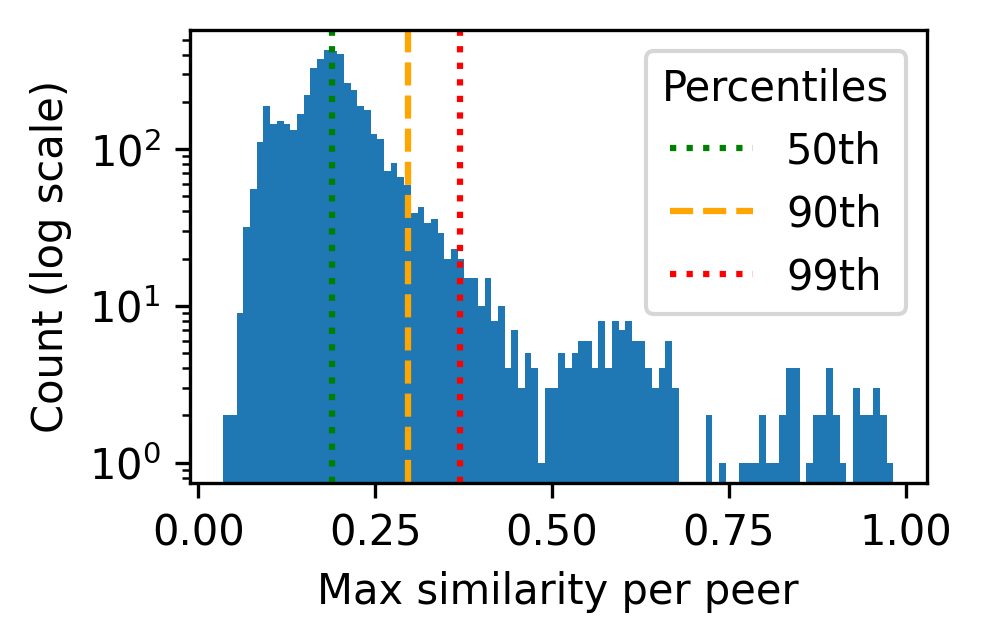

In [6]:
def plot_pl_sim(global_result_df):
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(global_result_df['max_pl_sim'], log=True, bins=100)
    plt.axvline(global_result_df['max_pl_sim'].quantile(0.50), color='green', linestyle=':', label='50th')
    plt.axvline(global_result_df['max_pl_sim'].quantile(0.9), color='orange', linestyle='--', label='90th')
    plt.axvline(global_result_df['max_pl_sim'].quantile(0.95), color='red', linestyle=':', label='99th')
    plt.xlabel(f'Max similarity per peer')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

plot_pl_sim(global_result_df)

# Subnets

Total of 10231 IPs and 8061 subnets
Overall distribution of subnets: 
    0.5th: 1.0
    0.75th: 1.0
    0.9th: 1.0
    0.95th: 2.0
    0.99th: 4.0
and 1576 ASNs
Overall distribution of ASNs: 
    0.5th: 1.0
    0.75th: 3.0
    0.9th: 10.0
    0.95th: 19.0
    0.99th: 76.03999999999996
subnet
209.222.252.0/24    253
91.198.115.0/24     253
193.142.4.0/24      253
199.116.84.0/24     253
100.42.27.0/24      253
185.220.101.0/24     41
45.90.185.0/24       22
193.32.127.0/24      21
45.84.107.0/24       16
192.42.116.0/24      15
68.235.46.0/24       14
185.220.100.0/24     14
195.47.238.0/24      13
146.70.126.0/24      11
193.32.248.0/24      11
103.106.0.0/24       10
185.65.134.0/24      10
185.213.154.0/24     10
185.209.199.0/24      9
185.209.198.0/24      8
Name: count, dtype: int64


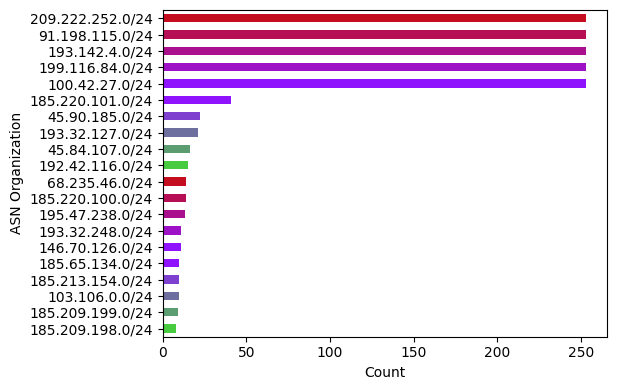

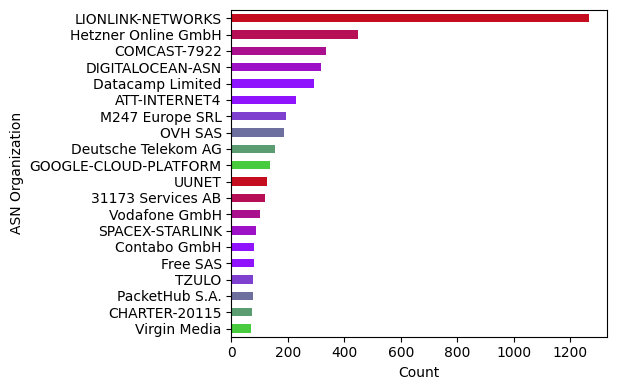

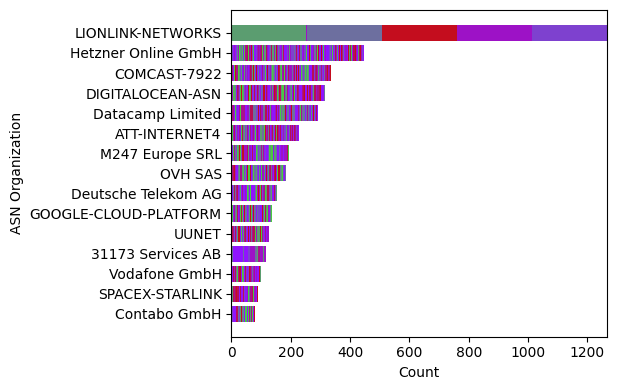

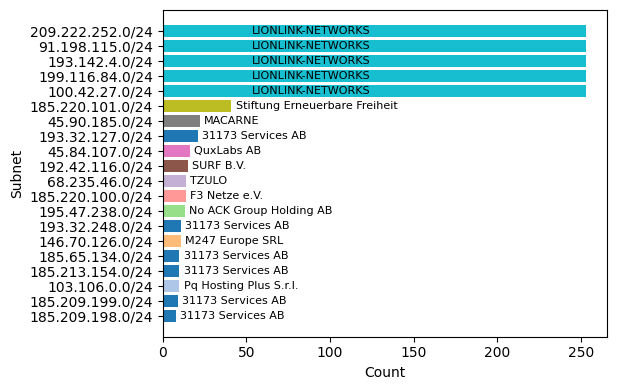

In [7]:
print(f"Total of {len(global_result_df['source_ip'])} IPs and {len(global_result_df['subnet'].unique())} subnets")
print(f"Overall distribution of subnets: ")
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99]
for q in quantiles:
    print(f"    {q}th: {global_result_df['subnet'].value_counts().quantile(q)}")
print(f"and {len(global_result_df['asn'].unique())} ASNs")
print(f"Overall distribution of ASNs: ")
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99]
for q in quantiles:
    print(f"    {q}th: {global_result_df['asn'].value_counts().quantile(q)}")
print(global_result_df['subnet'].value_counts().head(20))

colors, custom_cmap = retrieve_color_palette(n_colors=10, blends=['#49cb40', '#9013fe', '#c40d1e'])

global_result_df['subnet'].value_counts().head(20).sort_values().plot(
    kind='barh', 
    figsize=(6.27, 4),
    color=colors
)
plt.ylabel('ASN Organization')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

global_result_df['asn'].value_counts().head(20).sort_values().plot(
    kind='barh', 
    figsize=(6.27, 4),
    color=colors
)

plt.ylabel('ASN Organization')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# bar chart with stacked subnets
top_asns = global_result_df['asn'].value_counts().head(15).sort_values().index
asn_subset_data = {}

for asn in top_asns:
    asn_data = global_result_df[global_result_df['asn'] == asn]
    subnet_counts = asn_data['subnet'].value_counts()
    asn_subset_data[asn] = subnet_counts

fig, ax = plt.subplots(figsize=(6.27, 4))

bottom = pd.Series([0] * len(top_asns), index=top_asns)
color_idx = 0

for subnet in set().union(*[data.index for data in asn_subset_data.values()]):
    values = []
    for asn in top_asns:
        values.append(asn_subset_data[asn].get(subnet, 0))
    
    ax.barh(range(len(top_asns)), values, left=bottom, 
            label=subnet[:20] + '...' if len(subnet) > 20 else subnet,
            color=colors[color_idx % len(colors)])
    bottom += values
    color_idx += 1

ax.set_yticks(range(len(top_asns)))
ax.set_yticklabels(top_asns)
plt.xlabel('Count')
plt.ylabel('ASN Organization')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

top_subnets = global_result_df['subnet'].value_counts().head(20)

plot_data = []
for subnet in top_subnets.index:
    count = top_subnets[subnet]
    asn = global_result_df[global_result_df['subnet'] == subnet]['asn'].iloc[0]
    plot_data.append({'subnet': subnet, 'count': count, 'asn': asn})

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values('count')

# color mapping for ASNs
unique_asns = plot_df['asn'].unique()
cmap = plt.cm.tab20
colors = [cmap(i / len(unique_asns)) for i in range(len(unique_asns))]
#colors, custom_cmap = retrieve_color_palette(n_colors=len(unique_asns), blends=['#c40d1e', '#9013fe', '#49cb40']) 
asn_color_map = dict(zip(unique_asns, colors))

bar_colors = [asn_color_map[asn] for asn in plot_df['asn']]

fig, ax = plt.subplots(figsize=(6.27, 4))
bars = ax.barh(range(len(plot_df)), plot_df['count'], color=bar_colors)

ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df['subnet'])

# ASN labels
for i, (bar, asn) in enumerate(zip(bars, plot_df['asn'])):
    width = bar.get_width()
    if i < 15:
        ax.text(width + 0.01 * max(plot_df['count']), bar.get_y() + bar.get_height()/2, 
            f'{asn}', ha='left', va='center', fontsize=8)
    else:
        ax.text(width/5 + 0.01 * max(plot_df['count']), bar.get_y() + bar.get_height()/2, 
            f'{asn}', ha='left', va='center', fontsize=8)

ax.set_xlabel('Count')
ax.set_ylabel('Subnet')

plt.tight_layout()
plt.show()